In [1]:
import fastjet as fj
import fjcontrib
import pythia8
import pythiafjext as pyfj
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
# from tqdm import tnrange, tqdm_notebook
# import tqdm
import tqdm.notebook as tqdm
import joblib
import os

In [2]:
def deltas(jets, jets0):
    for i in range(len(jets)):
        yield jets0[i].perp() - jets[i].perp()

def create_and_init_pythia(config_strings=[]):
    pythia = pythia8.Pythia()
    for s in config_strings:
        pythia.readString(s)
    for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
        pythia.readString(extra_s)
    if pythia.init():
        return pythia
    return None

sconfig_pythia = [ "Beams:eCM = 8000.", "HardQCD:all = on", "PhaseSpace:pTHatMin = 100."]
pythia = create_and_init_pythia(sconfig_pythia)

# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
sd = fjcontrib.SoftDrop(0, 0.1, 1.0)

In [3]:
all_jets = []
for iEvent in tqdm.tqdm(range(1000), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -1, 1, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

In [4]:
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = fjcontrib.LundGenerator(jet_def_lund)

In [5]:
%%time
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 28.6 ms, sys: 3.88 ms, total: 32.5 ms
Wall time: 31.2 ms


In [6]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 35 ms, sys: 2.76 ms, total: 37.8 ms
Wall time: 36 ms


(array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.91649799, 0.98221489, 1.04793179, 1.11364869, 1.17936559,
        1.24508249, 1.31079939, 1.37651628, 1.44223318, 1.50795008,
        1.57366698, 1.63938388, 1.70510078, 1.77081768, 1.83653458,
        1.90225148, 1.96796837, 2.03368527, 2.09940217, 2.16511907,
        2.23083597, 2.29655287, 2.36226977, 2.42798667, 2.49370357,
        2.55942047, 2.62513736, 2.69085426, 2.75657116, 2.82228806,
        2.88800496, 2.95372186, 3.01943876, 3.08515566, 3.15087256,
        3.21658945, 3.28230635, 3.34802325, 3.41374015, 3.47945705,
        3.54517395, 3.61089085, 3.67660775, 3.74232465, 3.80804154,
        3.87375844, 3.93947534, 4.00519224, 4.07090914, 4.13662604,
        4.20234294, 4.26805984, 4.33377674, 4.39949363, 4.46521053,
   

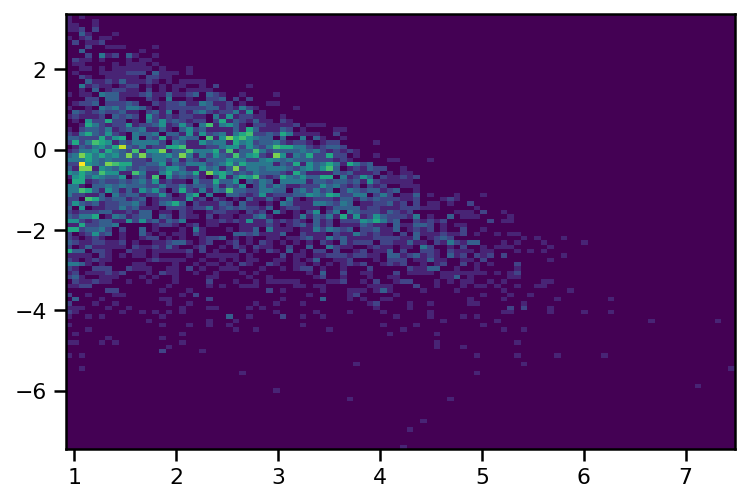

In [7]:
plt.hist2d(log_1oDelta, log_kt, bins=100)

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.91649799, 0.97374674, 1.0309955 , 1.08824425, 1.145493  ,
        1.20274175, 1.25999051, 1.31723926, 1.37448801, 1.43173676,
        1.48898552, 1.54623427, 1.60348302, 1.66073177, 1.71798053,
        1.77522928, 1.83247803, 1.88972678, 1.94697554, 2.00422429,
        2.06147304, 2.11872179, 2.17597055, 2.2332193 , 2.29046805,
        2.3477168 , 2.40496556, 2.46221431, 2.51946306, 2.57671181,
        2.63396057, 2.69120932, 2.74845807, 2.80570682, 2.86295558,
        2.92020433, 2.97745308, 3.03470183, 3.09195059, 3.14919934,
        3.20644809, 3.26369684, 3.3209456 , 3.37819435, 3.4354431 ,
        3.49269185, 3.54994061, 3.60718936, 3.66443811, 3.72168686,
        3.77893562, 3.83618437, 3.89343312, 3.95068187, 4.00793063,
   

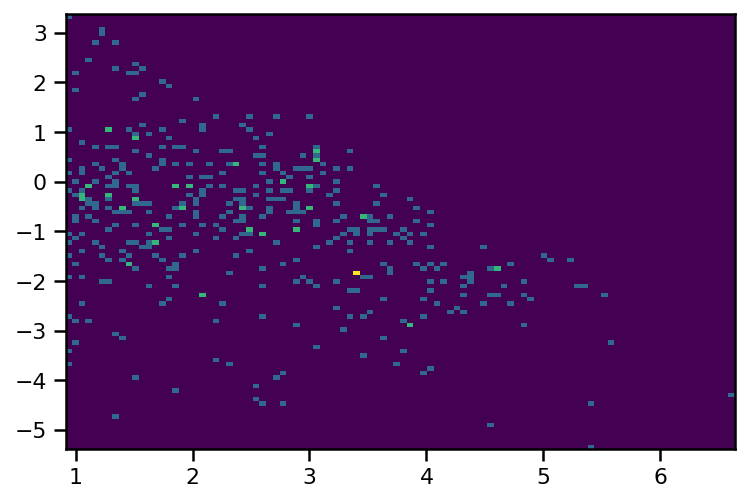

In [8]:
if not os.path.exists('test_lund_2d.joblib'):
    joblib.dump([log_1oDelta, log_kt], 'test_lund_2d.joblib') 
xy = joblib.load('test_lund_2d.joblib')
plt.hist2d(xy[0], xy[1], bins=100)